In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, cv, Pool
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)

In [2]:
df_1 = pd.read_json('DATASET_FINAL.json')

df = df_1.copy()



In [3]:
# Groupement des acteurs 1, 2, 3 , scénaristes, réalisateurs, et distributeurs qui font plus de 500k entrées 
# + ajout d'un groupe "mid" entre 250k et 500k

# Acteur 1
df_actor_1 = df.groupby('actor_1')['weekly_entrances'].mean().reset_index()
df_actor_1_mid = df_actor_1[(df_actor_1['weekly_entrances'] < 500001) & (df_actor_1['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_1 = df_actor_1[df_actor_1['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 2
df_actor_2 = df.groupby('actor_2')['weekly_entrances'].mean().reset_index()
df_actor_2_mid = df_actor_2[(df_actor_2['weekly_entrances'] < 500001) & (df_actor_2['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_2 = df_actor_2[df_actor_2['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 3
df_actor_3 = df.groupby('actor_3')['weekly_entrances'].mean().reset_index()
df_actor_3_mid = df_actor_3[(df_actor_3['weekly_entrances'] < 500001) & (df_actor_3['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_3 = df_actor_3[df_actor_3['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Réalisateurs
df_directors = df.groupby('directors')['weekly_entrances'].mean().reset_index()
df_directors_mid = df_directors[(df_directors['weekly_entrances'] < 500001) & (df_directors['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_directors = df_directors[df_directors['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Scénaristes
df_writer = df.groupby('writer')['weekly_entrances'].mean().reset_index()
df_writer_mid = df_writer[(df_writer['weekly_entrances'] < 500001) & (df_writer['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_writer = df_writer[df_writer['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Distributeurs
df_distribution = df.groupby('distribution')['weekly_entrances'].mean().reset_index()
df_distribution_mid = df_distribution[(df_distribution['weekly_entrances'] < 500001) & (df_distribution['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_distribution = df_distribution[df_distribution['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)


In [4]:
# Création des colonnes "top" et "top_mid" pour les différents groupes

df['top_actor_1'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1['actor_1'].to_list() else 0)
df['top_actor_1_mid'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1_mid['actor_1'].to_list() else 0)

df['top_actor_2'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2['actor_2'].to_list() else 0)
df['top_actor_2_mid'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2_mid['actor_2'].to_list() else 0)

df['top_actor_3'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3['actor_3'].to_list() else 0)
df['top_actor_3_mid'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3_mid['actor_3'].to_list() else 0)

df['top_director'] = df['directors'].apply(lambda x: 1 if x in df_directors['directors'].to_list() else 0)
df['top_director_mid'] = df['directors'].apply(lambda x: 1 if x in df_directors_mid['directors'].to_list() else 0)

df['top_writer'] = df['writer'].apply(lambda x: 1 if x in df_writer['writer'].to_list() else 0)
df['top_writer_mid'] = df['writer'].apply(lambda x: 1 if x in df_writer_mid['writer'].to_list() else 0)

df['top_distribution'] = df['distribution'].apply(lambda x: 1 if x in df_distribution['distribution'].to_list() else 0)
df['top_distribution_mid'] = df['distribution'].apply(lambda x: 1 if x in df_distribution_mid['distribution'].to_list() else 0)


In [5]:
# Définition des bornes de classification (en dollars)
bins = [0,5_000_000, 30_000_000, 100_000_000, float('inf')]

# Noms des catégories correspondantes
labels = [
    # "Ultra low budget",
    "Low budget",
    "Mid budget",
    "High budget",
    "Blockbuster / AAA"
]

# Création de la nouvelle colonne "budget_category"
df['budget_category'] = pd.cut(df['budget'], bins=bins, labels=labels, right=False)

# Affichage du résultat
df.head()

df['top_pays'] = df.country.apply(lambda x : 1 if x in (['France','Etats-Unis','Grande-Bretagne']) else 0)

In [7]:
df["summer"] = df["released_date"].apply(lambda x: 1 if ((x.month == 6 and x.day >= 21) or x.month in [7, 8] or (x.month == 9 and x.day < 22)) else 0)
df["automn"] = df["released_date"].apply(lambda x: 1 if ((x.month == 9 and x.day >= 22) or x.month in [10, 11] or (x.month == 12 and x.day < 21)) else 0)
df["winter"] = df["released_date"].apply(lambda x: 1 if ((x.month == 12 and x.day >= 21) or x.month in [1, 2] or (x.month == 3 and x.day < 20)) else 0)
df["spring"] = df["released_date"].apply(lambda x: 1 if ((x.month == 3 and x.day >= 21) or x.month in [4, 5] or (x.month == 6 and x.day < 21)) else 0)

df["is_covid"] = df["released_date"].apply(lambda x: 1 if (
    (x >= pd.to_datetime("2020-03-17") and x <= pd.to_datetime("2020-05-11")) or
    (x >= pd.to_datetime("2020-10-30") and x <= pd.to_datetime("2020-12-15")) or
    (x >= pd.to_datetime("2021-04-03") and x <= pd.to_datetime("2021-05-03"))
) else 0)

df["post_streaming"] = df["released_date"].apply(lambda x: 1 if x >= pd.to_datetime("2014-09-15") else 0)

df["summer_holidays"] = df["released_date"].apply(lambda x: 1 if x.month >= 7 or (x.month <= 9 and x.day < 10) else 0)

df["christmas_period"] = df["released_date"].apply(lambda x: 1 if (x.month == 12 and x.day >= 20) or (x.month == 1 and x.day <= 5) else 0)

df["is_award_season"] = df["released_date"].apply(lambda x: 1 if (x.month == 2 or (x.month == 3 and x.day <= 10)) else 0)

df['month'] = df['released_date'].dt.month

In [8]:
features_of_interest = [
    # "actor_1",
    # "actor_2",
    # 'actor_3',
    # "directors",
    #  "writer",
    # "distribution",
    #"fr_title",
    'released_year',
    "country",
    #"budget",
    'category',
    'classification',
    'duration_minutes', 
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    'top_distribution',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    #'budget_category',
    'top_pays',
    # 'summer',
    # 'automn',
    # 'winter',
    # 'spring',
    # 'is_covid',
    'post_streaming',
    'summer_holidays',
    'christmas_period',
    'is_award_season',
    #'month',
]


numerical_column = [
    #"budget",
    'released_year',
    "duration_minutes",
    #'month',

]


ordinal_column = [
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    'top_distribution',
    'top_pays',
    #     'summer',
    # 'automn',
    # 'winter',
    # 'spring',
    # 'is_covid',
    'post_streaming',
    'summer_holidays',
    'christmas_period',
    'is_award_season',
]

categorical_column = [
        # "actor_1",
        # "actor_2",
        # "actor_3",
        # "directors",
        # "writer",
        # "distribution",
    #"fr_title",
    "country",
    'category',
    'classification',
    #'budget_category'

]

#
target_name = "weekly_entrances"
data, target, numerical_data,categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[categorical_column]
)


In [10]:


X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.9, random_state=42, stratify = df['top_pays'])

In [11]:

sample_weights = np.ones(len(y_train))
success_mask = y_train > 200000
sample_weights[success_mask] = 2

preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("numeric", RobustScaler(), numerical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column)
    ],
    remainder="passthrough",
)

# catboost_model = make_pipeline(preprocessor,CatBoostRegressor(depth=4,iterations=300,l2_leaf_reg=1,learning_rate=0.07))
catboost_model = make_pipeline(preprocessor,CatBoostRegressor())
# catboost_model.fit(X_train,y_train)
catboost_model.fit(X_train,y_train, catboostregressor__sample_weight=sample_weights)

# Prédictions sur le test
y_pred = catboost_model.predict(X_test)

# Calcul des métriques
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
errors = y_pred - y_test
sum_errors = np.sum(errors)
mean_errors = np.mean(errors)
print(f"✅ RMSE (test) Catboost: {rmse:.4f}")
print(f"✅ MAPE (test) Catboost: {mape:.4f}")
print(f"🔥 Somme des erreurs: {sum_errors:.4f}")
print(f"🔥 moyenne des erreurs: {mean_errors:.4f}")

Learning rate set to 0.055066
0:	learn: 398394.7208641	total: 52ms	remaining: 51.9s
1:	learn: 385248.7453686	total: 53.9ms	remaining: 26.9s
2:	learn: 373061.6597519	total: 55.3ms	remaining: 18.4s
3:	learn: 362068.8453898	total: 56.4ms	remaining: 14.1s
4:	learn: 351152.1093288	total: 57.9ms	remaining: 11.5s
5:	learn: 340932.8911245	total: 59.6ms	remaining: 9.88s
6:	learn: 331779.5231021	total: 61.4ms	remaining: 8.71s
7:	learn: 322952.2033111	total: 63ms	remaining: 7.81s
8:	learn: 314654.5291738	total: 64.4ms	remaining: 7.09s
9:	learn: 307562.4007638	total: 66ms	remaining: 6.53s
10:	learn: 300705.2264965	total: 67.8ms	remaining: 6.09s
11:	learn: 293688.1349407	total: 69.4ms	remaining: 5.72s
12:	learn: 287487.0750846	total: 71ms	remaining: 5.39s
13:	learn: 281791.9515179	total: 72.4ms	remaining: 5.1s
14:	learn: 276805.4540946	total: 73.9ms	remaining: 4.85s
15:	learn: 271685.7495065	total: 75.3ms	remaining: 4.63s
16:	learn: 267108.8789124	total: 76.8ms	remaining: 4.44s
17:	learn: 263065.32

In [13]:
import pandas as pd
import numpy as np

# Étape 1 : Extraire le modèle CatBoost et le préprocessor depuis le pipeline
fitted_preprocessor = catboost_model.named_steps["columntransformer"]
fitted_model = catboost_model.named_steps["catboostregressor"]

# Étape 2 : Récupérer tous les noms de features après transformation
# - Categorical (OneHotEncoder)
cat_feat_names = fitted_preprocessor.named_transformers_["categorical"]\
    .get_feature_names_out(categorical_column)

# - Numeric (RobustScaler)
num_feat_names = numerical_column

# - Ordinal (OrdinalEncoder)
ord_feat_names = ordinal_column

# - Autres (remainder passthrough)
# Ici on a rien en plus, donc on concatène
feature_names = np.concatenate([cat_feat_names, num_feat_names, ord_feat_names])

# Étape 3 : Récupérer les importances du modèle
importances = fitted_model.feature_importances_

# Étape 4 : Créer un DataFrame trié avec noms + importances
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("📊 Feature Importances (top 30) :")
print(feat_imp_df.head(30))

# Étape 5 : Somme des valeurs d'origine pour chaque colonne d'intérêt
print("\n🧮 Sommes des valeurs par feature (dans les données brutes) :")

for col in numerical_column + ordinal_column:
    print(f"{col:25}: {df[col].sum():,.0f}")


📊 Feature Importances (top 30) :
                              Feature  Importance
108                        top_writer   15.584942
103                  duration_minutes   10.984636
106                       top_actor_3   10.750319
107                      top_director    9.280003
105                       top_actor_2    6.513992
104                       top_actor_1    6.303234
102                     released_year    6.162403
113                    top_writer_mid    3.389505
111                   top_actor_3_mid    3.141860
120                   is_award_season    2.411492
109                   top_actor_1_mid    2.397025
110                   top_actor_2_mid    2.309799
115                  top_distribution    2.205218
78                   category_Comédie    2.062670
83                   category_Fantasy    1.996001
26                     country_France    1.952047
112                  top_director_mid    1.945018
114              top_distribution_mid    1.309621
118              

In [14]:
items_list = feat_imp_df['Feature'].unique()
to_remove = ['budget', 'top_writer', 'duration_minutes', 'top_actor_3',
             'top_actor_1', 'top_actor_2', 'top_director']

items_list = [item for item in items_list if item not in to_remove]

for category in categorical_column:

    list_sum = 0
    to_drop = []

    for cat in items_list:
        if category in cat:
            list_sum += feat_imp_df.loc[feat_imp_df['Feature'] == cat, 'Importance'].values[0]
            to_drop.append(cat)

    feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(to_drop)]

    new_row = pd.DataFrame([{'Feature': category, 'Importance': list_sum}])
    feat_imp_df = pd.concat([feat_imp_df, new_row], axis=0, ignore_index=True)

    print(f'la somme de {category} est de {list_sum}')

# Affichage final
feat_imp_df


la somme de country est de 2.944579413942552
la somme de category est de 8.195801941482358
la somme de classification est de 2.673143031043843


Feature  Importance
0             top_writer   15.584942
1       duration_minutes   10.984636
2            top_actor_3   10.750319
3           top_director    9.280003
4            top_actor_2    6.513992
5            top_actor_1    6.303234
6          released_year    6.162403
7         top_writer_mid    3.389505
8        top_actor_3_mid    3.141860
9        is_award_season    2.411492
10       top_actor_1_mid    2.397025
11       top_actor_2_mid    2.309799
12      top_distribution    2.205218
13      top_director_mid    1.945018
14  top_distribution_mid    1.309621
15       summer_holidays    1.193036
16        post_streaming    0.191468
17              top_pays    0.067851
18      christmas_period    0.045051
19               country    2.944579
20              category    8.195802
21        classification    2.673143

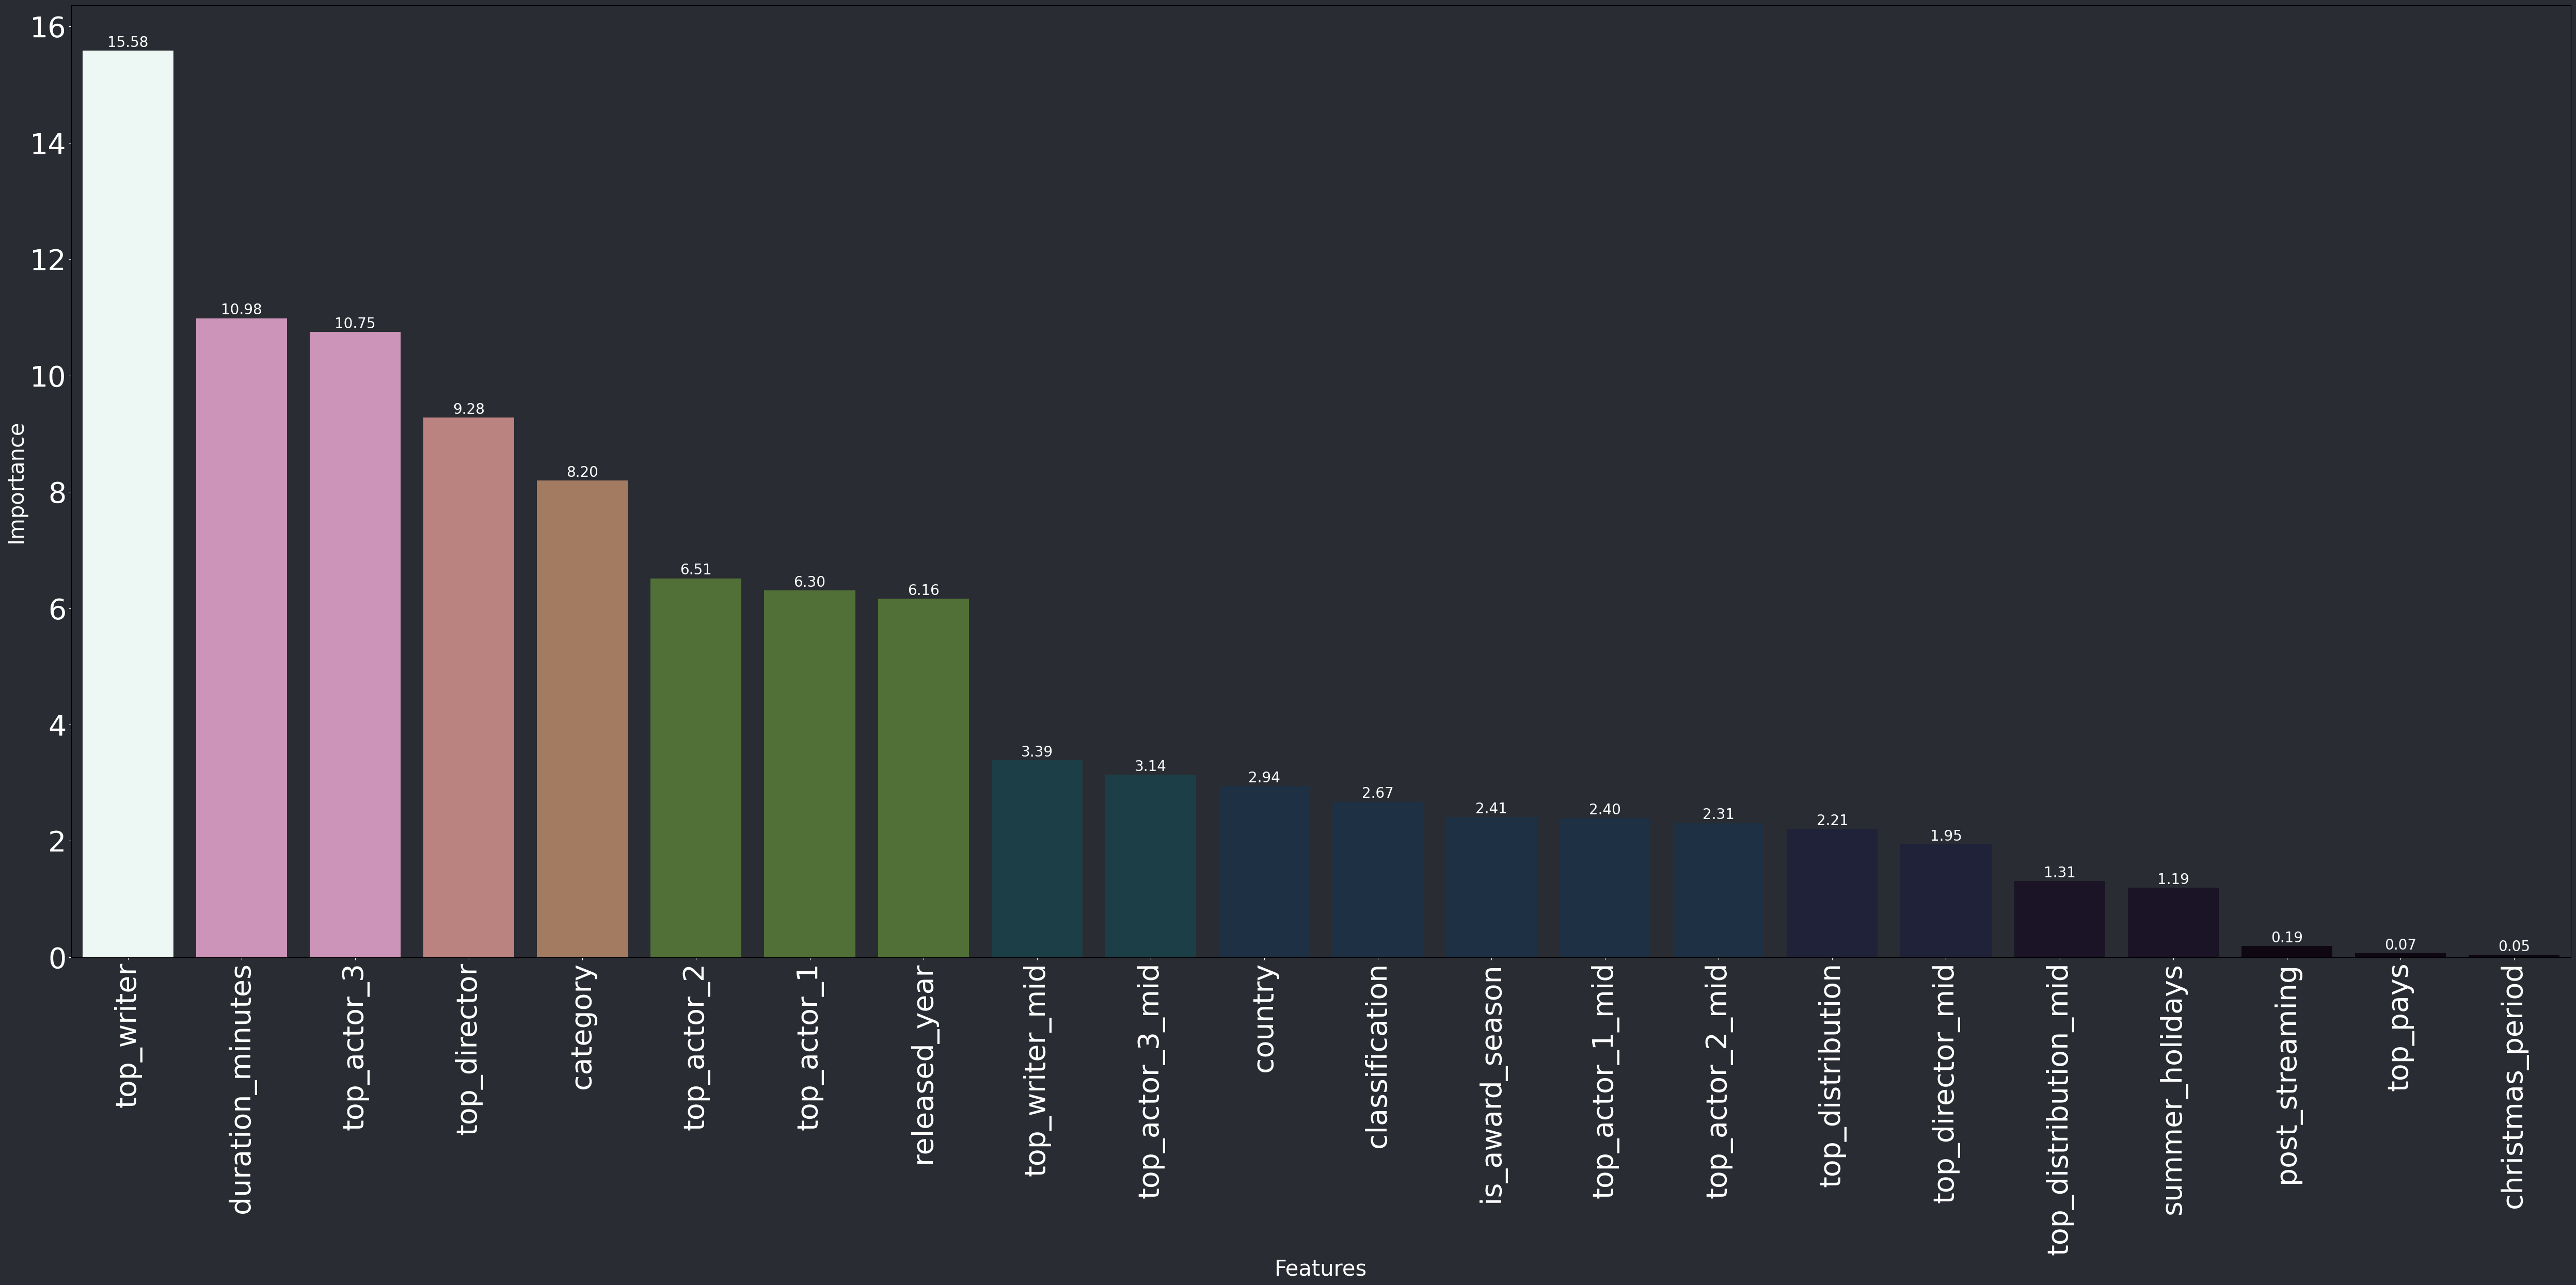

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tri des données
feat_imp_df_sorted = feat_imp_df.sort_values(by='Importance', ascending=False)

# Normalisation de l'importance pour appliquer la couleur
norm = (feat_imp_df_sorted['Importance'] - feat_imp_df_sorted['Importance'].min()) / \
       (feat_imp_df_sorted['Importance'].max() - feat_imp_df_sorted['Importance'].min())

# Création d'une palette artistique violet-blanc stylée
palette = sns.color_palette("cubehelix", n_colors=len(feat_imp_df_sorted))
colors = [palette[int(n * (len(palette) - 1))] for n in norm]

# Création de la figure avec fond noir
fig, ax = plt.subplots(figsize=(50, 25))
fig.patch.set_facecolor('#292c32')
ax.set_facecolor('#292c32')

# Barplot avec couleurs personnalisées
sns.barplot(
    x=feat_imp_df_sorted["Feature"],
    y=feat_imp_df_sorted["Importance"],
    palette=colors,
    ax=ax
)

# Labels et style
ax.set_xlabel("Features", fontsize=30, color='white')
ax.set_ylabel("Importance", fontsize=30, color='white')
ax.tick_params(axis='both', labelsize=40, colors='white')
plt.xticks(rotation=90)

# Optionnel : ajouter les valeurs d’importance sur les barres
for i, (feature, importance) in enumerate(zip(feat_imp_df_sorted["Feature"], feat_imp_df_sorted["Importance"])):
    ax.text(i, importance + 0.01, f"{importance:.2f}", ha='center', va='bottom', color='white', fontsize=20)

plt.tight_layout()
plt.show()


In [ ]:
# 2. Grille de paramètres à tester (tu peux en ajouter)

param_grid = {
    'catboostregressor__depth': [4, 6, 8, 10],
    'catboostregressor__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'catboostregressor__iterations': [200, 300, 500, 700],
    'catboostregressor__l2_leaf_reg': [1, 3, 5, 7, 9],
}


# 3. GridSearchCV
grid_search = GridSearchCV(
    catboost_model,
    param_grid,
    cv=3,  # ou 5 pour une validation croisée plus robuste
    scoring='neg_root_mean_squared_error',  # on veut minimiser le RMSE
    n_jobs=4,
    verbose=100
)

# 4. Entraînement
grid_search.fit(X_train, y_train)

# 5. Résultats
print("✅ Best params:", grid_search.best_params_)
print(f"✅ Best RMSE: {-grid_search.best_score_:.4f}")

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV 1/3; 1/400] START catboostregressor__depth=4, catboostregressor__iterations=200, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01
[CV 3/3; 1/400] START catboostregressor__depth=4, catboostregressor__iterations=200, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01
[CV 2/3; 1/400] START catboostregressor__depth=4, catboostregressor__iterations=200, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.01
[CV 1/3; 2/400] START catboostregressor__depth=4, catboostregressor__iterations=200, catboostregressor__l2_leaf_reg=1, catboostregressor__learning_rate=0.03
0:	learn: 338616.3556546	total: 47.9ms	remaining: 9.52s
1:	learn: 336649.8022243	total: 49.9ms	remaining: 4.93s
2:	learn: 334732.7413272	total: 50.5ms	remaining: 3.32s
3:	learn: 332782.2512292	total: 51.4ms	remaining: 2.52s
4:	learn: 330808.0228021	total: 52ms	remaining: 2.03s
5:	learn: 329035.0701824	total